In [1]:
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input, Model, layers, optimizers, losses, metrics, datasets
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 忽略低级别警告

root_URL = 'C:\\Users\\lenovo\\Desktop\\'

# 加载train

In [2]:
# 读入 pkl
pickle_file = 'svhn_raw.pkl'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data = save['train_data']
    del save
    print('Train set', len(train_data))

Train set 33402


In [3]:
class Dataset:
    """crop images and save them to numpy ndarray"""
    
    def __init__(self, digitStruct, folder):
        self.digitStruct = digitStruct
        self.folder = folder
        
    def setDataset(self):
        self.dataset = np.ndarray(shape=(len(self.digitStruct), 64, 64), dtype='float32')
        
        # 1 length + 5 labels, 0 represents none
        self.labels = np.ones(shape=(len(self.digitStruct), 6), dtype='int') * 10 
        
    def getDataset(self):
        
        self.setDataset()
        
        for i in range(len(self.digitStruct)):

            fin = os.path.join(self.folder, self.digitStruct[i]['Name'])
            im = Image.open(fin)
            
            boxes = self.digitStruct[i]['Bbox']
            
            if len(boxes) > 5:
                print(fin, "has more than 5 digits")
            else:
                self.labels[i,0] = len(boxes)
                self.labels[i,1:len(boxes)+1] = [int(j['label'] if j['label'] != 10 else 0) for j in boxes]
            
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            
            box = self.img_box(im, left, top, height, width)

            size = (64, 64)
            region = im.crop(box).resize(size)
            region = self.normalization(region)
#             print(region.shape)
            self.dataset[i,:,:] = region[:,:]
            
        print('dataset:',self.dataset.shape)
        print('labels:',self.labels.shape)
        return self.dataset, self.labels
        
    def img_box(self, im, left, top, height, width):

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = min(im.size[1], im_top + im_height * 1.05)
        im_right = min(im.size[0], im_left + im_width * 1.05)

        return (im_left, im_top, im_right, im_bottom)


    def normalization(self, img):
#         im = self.rgb2gray(img) # RGB to greyscale
        im = img.convert('L')
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        return (im - mean) / std  

In [4]:
train_dataset = Dataset(train_data, root_URL + 'data\\train')
train_images, train_labels = train_dataset.getDataset()

print(train_images.shape)
print(train_labels.shape)

C:\Users\lenovo\Desktop\data\train\29930.png has more than 5 digits
dataset: (33402, 64, 64)
labels: (33402, 6)
(33402, 64, 64)
(33402, 6)


In [5]:
train_images = np.delete(train_images, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

print(train_images.shape)
print(train_labels.shape)

(33401, 64, 64)
(33401, 6)


# 加载test

In [6]:
# 加载数据
pickle_file = root_URL + 'svhn_dataset_112x56.pkl'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_images = save['test_images']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Test Shape:', test_images.shape, test_labels.shape)

Test Shape: (13068, 56, 112) (13068, 6)


In [7]:
# test bbox
test_len = len(test_images)
test_bboxes = np.zeros(shape=(test_len, 4), dtype='float32')

model = tf.keras.models.load_model('my_model_bbox_500.h5')
for i in range(test_len):
    x = tf.expand_dims(test_images[i], axis=0)
    x = tf.expand_dims(x, axis=-1)
    y = model.predict(x, verbose=0)
    test_bboxes[i] = y
    
print(test_bboxes)

[[42.591873   4.9120226 70.923584  48.121773 ]
 [60.36004    5.3684783 88.787186  34.532227 ]
 [39.058296   9.150379  70.7265    44.778923 ]
 ...
 [25.268398  14.634584  62.775154  43.23011  ]
 [48.04538   16.495087  66.39281   38.876076 ]
 [40.949486   9.921697  71.528824  44.986916 ]]


In [8]:
print(test_bboxes[90])

[47.310925 11.98835  66.08966  38.63517 ]


In [9]:
def normalization(img):

    im = img.convert('L')
    mean = np.mean(im, dtype='float32')
    std = np.std(im, dtype='float32', ddof=1)
    return (im - mean) / std  
   
width_size = 112
height_size = 56

del test_images
test_images = np.ndarray(shape=(test_len, 64, 64), dtype='float32')

for i in range(test_len):
    
    fin = os.path.join(root_URL, 'data', 'test', str(i+1)+ '.png')
    im = Image.open(fin)
    
    bbox = test_bboxes[i]
    
    im_left = bbox[0] * im.size[0] / width_size
    im_top = bbox[1] * im.size[1] / height_size
    im_right = bbox[2] * im.size[0] / width_size
    im_bottom = bbox[3] * im.size[1] / height_size
    
    box = [im_left, im_top, im_right, im_bottom]

    size = (64, 64)
    region = im.crop(box).resize(size)
    region = normalization(region)
    #             print(region.shape)
    test_images[i,:,:] = region[:,:]
    
print(test_images[0])

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


[[0.33797434 0.33797434 0.33797434 ... 0.33797434 0.33797434 0.33797434]
 [0.33797434 0.33797434 0.33797434 ... 0.33797434 0.33797434 0.33797434]
 [0.33797434 0.33797434 0.33797434 ... 0.33797434 0.33797434 0.33797434]
 ...
 [0.82675284 0.82675284 0.82675284 ... 0.9489474  0.9489474  0.9489474 ]
 [0.82675284 0.82675284 0.8878501  ... 0.9489474  0.8878501  0.8878501 ]
 [0.82675284 0.82675284 0.8878501  ... 0.8878501  0.8878501  0.8878501 ]]


[ 1  2 10 10 10 10]


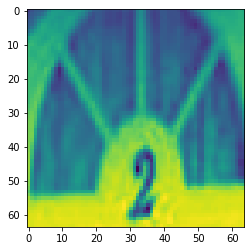

In [10]:
num = 96
plt.imshow(test_images[num,:,:])
print(test_labels[num])

In [11]:
# 保存 dataset
pickle_file = 'svhn_dataset_64x64.pkl'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_images': train_images,
    'train_labels': train_labels,
    'test_images': test_images,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done


In [2]:
# 加载数据
pickle_file = root_URL + 'svhn_dataset_64x64.pkl'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_images = save['train_images']
    train_labels = save['train_labels']
    test_images = save['test_images']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Train Shape:', train_images.shape, train_labels.shape)
    print('Test Shape:', test_images.shape, test_labels.shape)

Train Shape: (33401, 64, 64) (33401, 6)
Test Shape: (13068, 64, 64) (13068, 6)


[ 3  2  1  0 10 10]


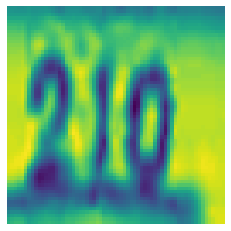

In [8]:
num = 1
plt.imshow(test_images[num,:,:])
plt.axis('off')
plt.savefig('65x65.png')
print(test_labels[num])